# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

## Table of Contents

### 1. What is DBSCAN?

### 2. DBSCAN in Scikit-Learn

### 3. Evaluation of Clustering

### 4. Important Considerations for DBSCAN




### 1. What is DBSCAN?

DBSCAN is a density-based clustering algorithm that groups together points that are closely packed together, while labeling points in low-density regions as outliers

## How DBSCAN Works:

### Step 1: Define Density
- For each point, find its **neighbors within a distance `eps`**.  
- Count how many neighbors are inside this radius.  

A point is considered a **core point** if it has at least `min_samples` neighbors


### Step 2: Identify Core, Border and Noise Points

1. **Core point** → dense region  
2. **Border point** → not dense itself, but within `eps` of a core point  
3. **Noise point** → neither core nor border (isolated points)
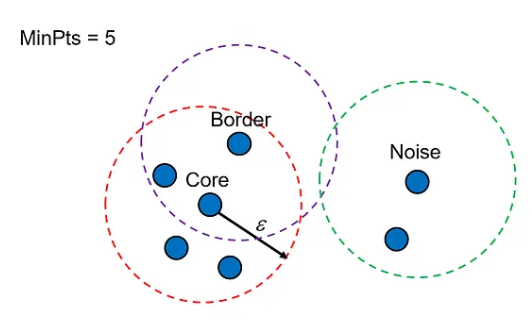

### Step 3: Form Clusters
- Start with an unvisited point:
  1. If it is a **core point**, create a new cluster  
  2. Expand the cluster by adding **all neighbors** within `eps`
- Recursively check neighbors:
  - If neighbor is a core point, add its neighbors too  
  - If neighbor is a border point, add it to the cluster

- Continue until all reachable points from this core point are assigned.


### Step 4: Handle Remaining Points
- Any point that is not assigned to a cluster is labeled as **noise (-1)**.


### Step 5: Output
- Each cluster gets a unique label  
- Noise points are labeled `-1`  

###Result: clusters + noise points

## 2. DBSCAN in Scikit-Learn

### **Most Important Parameters**

#### **1. `epslon`**

Maximum distance between two points for them to be considered neighbors. Controls how close points must be to form clusters

- Smaller `eps` → more points are labeled as **noise**  

- Larger `eps` → clusters may merge, fewer noise points  


#### **2. `min_samples`**

Minimum number of points required to form a **dense region (core point)**. Determines how strict the algorithm is about forming clusters.

**Default:** 5  

- Smaller → clusters form more easily, fewer noise points

- Larger → only dense regions form clusters, more noise points  

**Notes:**  

Often set to **double number of dimension** for small datasets, or higher for noisy data

#### **3. `metric`**
  
Distance metric used to calculate proximity between points. Determines which points are considered “neighbors”

**Default:** `euclidean`

**Common options:**  
  - `euclidean` → straight-line distance; most common for numeric features  
  - `manhattan` → sum of absolute differences; robust to outliers  
  - `cosine` → measures angle between vectors; useful for text embeddings  

**Rule of thumb:**  
Choice of metric affects cluster shape and which points are considered close.  

## Apply DBSCAN to a simple Dataset

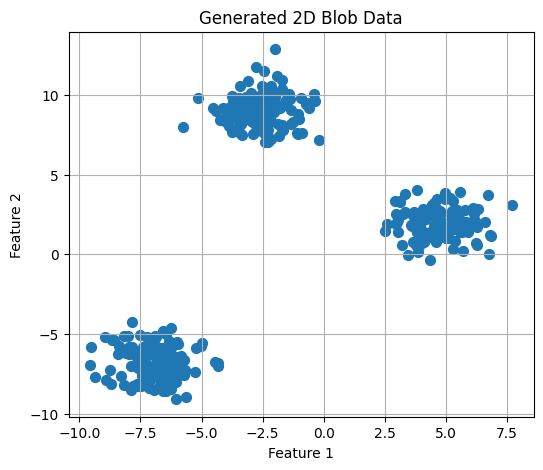

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns
from sklearn.cluster import DBSCAN


# Generate 2D data: 400 points, 3 centers
X, y = make_blobs(n_samples=400, n_features=2, centers=3, random_state=42)

# Plot the dataset
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=50)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated 2D Blob Data")
plt.grid(True)
plt.show()

In [2]:

# Create DBSCAN model
dbscan = DBSCAN(
    eps=1.2,        # neighborhood radius
    min_samples=5,  # minimum points to form a cluster
    metric='euclidean'
)

# Fit and predict cluster labels
labels = dbscan.fit_predict(X)

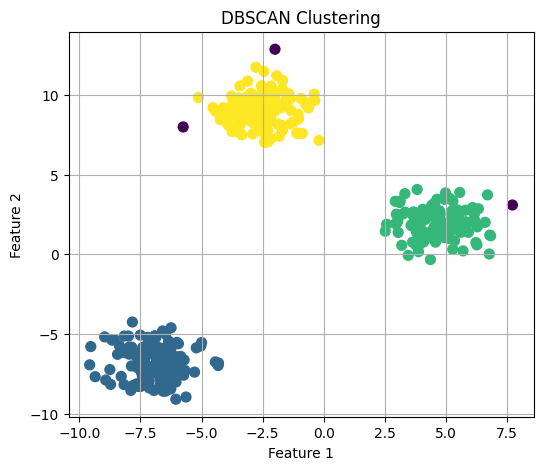

In [3]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=50)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering")
plt.grid(True)
plt.show()


In [4]:
from sklearn.metrics import silhouette_score

# Compute silhouette score, ignoring noise points
mask = labels != -1
score = silhouette_score(X[mask], labels[mask])
print("Silhouette Score (excluding noise points):", score)

Silhouette Score (excluding noise points): 0.8480963132111413


In [5]:
outlier_percent = []

for eps in np.linspace(0.001,3,50):

    # Create Model
    dbscan = DBSCAN(eps=eps)
    cluster_labels = dbscan.fit_predict(X)


    # Log percentage of points that are outliers
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(cluster_labels)

    outlier_percent.append(perc_outliers)

Text(0.5, 0, 'Epsilon Value')

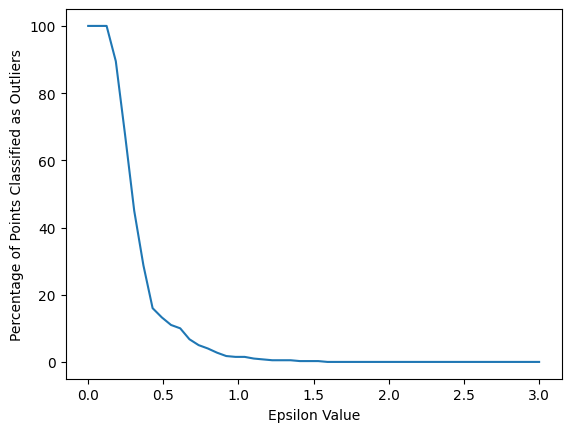

In [6]:
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Percentage of Points Classified as Outliers")
plt.xlabel("Epsilon Value")

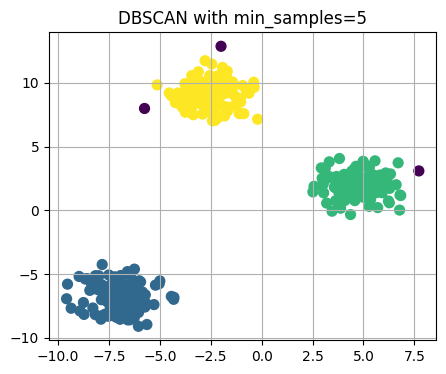

min_samples=5 → Silhouette Score: 0.848


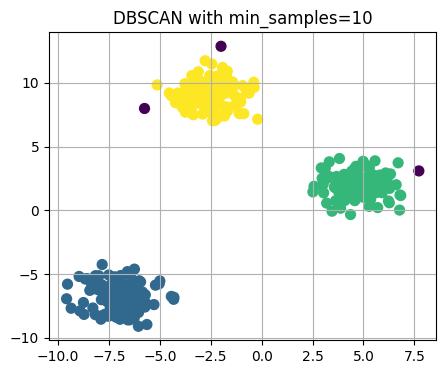

min_samples=10 → Silhouette Score: 0.848


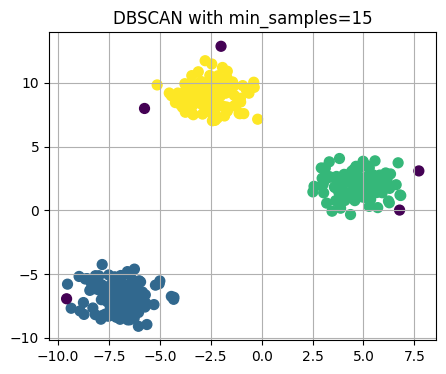

min_samples=15 → Silhouette Score: 0.849


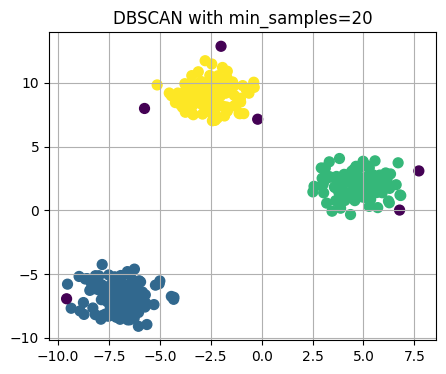

min_samples=20 → Silhouette Score: 0.850


In [7]:
#Varying min_samples
min_samples_values = [5, 10, 15, 20]

for min_samples in min_samples_values:
    # Apply DBSCAN
    dbscan = DBSCAN(eps=1.2, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    # Visualize clusters
    plt.figure(figsize=(5,4))
    plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=50)
    plt.title(f"DBSCAN with min_samples={min_samples}")
    plt.grid(True)
    plt.show()

    # Compute silhouette score (ignore noise)
    mask = labels != -1  # exclude noise
    if len(set(labels[mask])) > 1:  # silhouette score requires >=2 clusters
        score = silhouette_score(X[mask], labels[mask])
        print(f"min_samples={min_samples} → Silhouette Score: {score:.3f}")
    else:
        print(f"min_samples={min_samples} → Too few clusters to compute silhouette score")

## Task 2B: DBSCAN

Dataset: `CC GENERAL.csv`  
Goal: Use **DBSCAN** to find clusters of customers and identify potential outliers.


## 1. Exploratory Data Analysis (EDA)



In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
df = pd.read_csv("CC GENERAL.csv")
df.head()
df.info()
df.shape

<class 'pandas.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   str    
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHASES_TRX    

(8950, 18)

In [9]:
# -----------------------------------------
# Select numeric features automatically
# -----------------------------------------
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
print("Numeric Features:")
print(numeric_features)
# Select columns with object data type (typically categorical or string)
categorical_features = df.select_dtypes(include=['object']).columns
print("\nCategorical Features:")
print(categorical_features)

# Print number of numeric features
print("Number of Numeric Features:", len(numeric_features))
# Print number of categorical features
print("Number of Categorical Features:", len(categorical_features))
# Print total number of features
print("Total Number of Features:", df.shape[1])

# The dataset consists mainly of numeric features representing credit card usage behavior.
# There is only one categorical feature (CUST_ID), which serves as a unique identifier and does not carry analytical value for clustering.


Numeric Features:
Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='str')

Categorical Features:
Index(['CUST_ID'], dtype='str')
Number of Numeric Features: 17
Number of Categorical Features: 1
Total Number of Features: 18


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10444\618100440.py:8: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = df.select_dtypes(include=['object']).columns


Statistical Summary of Numeric Features:


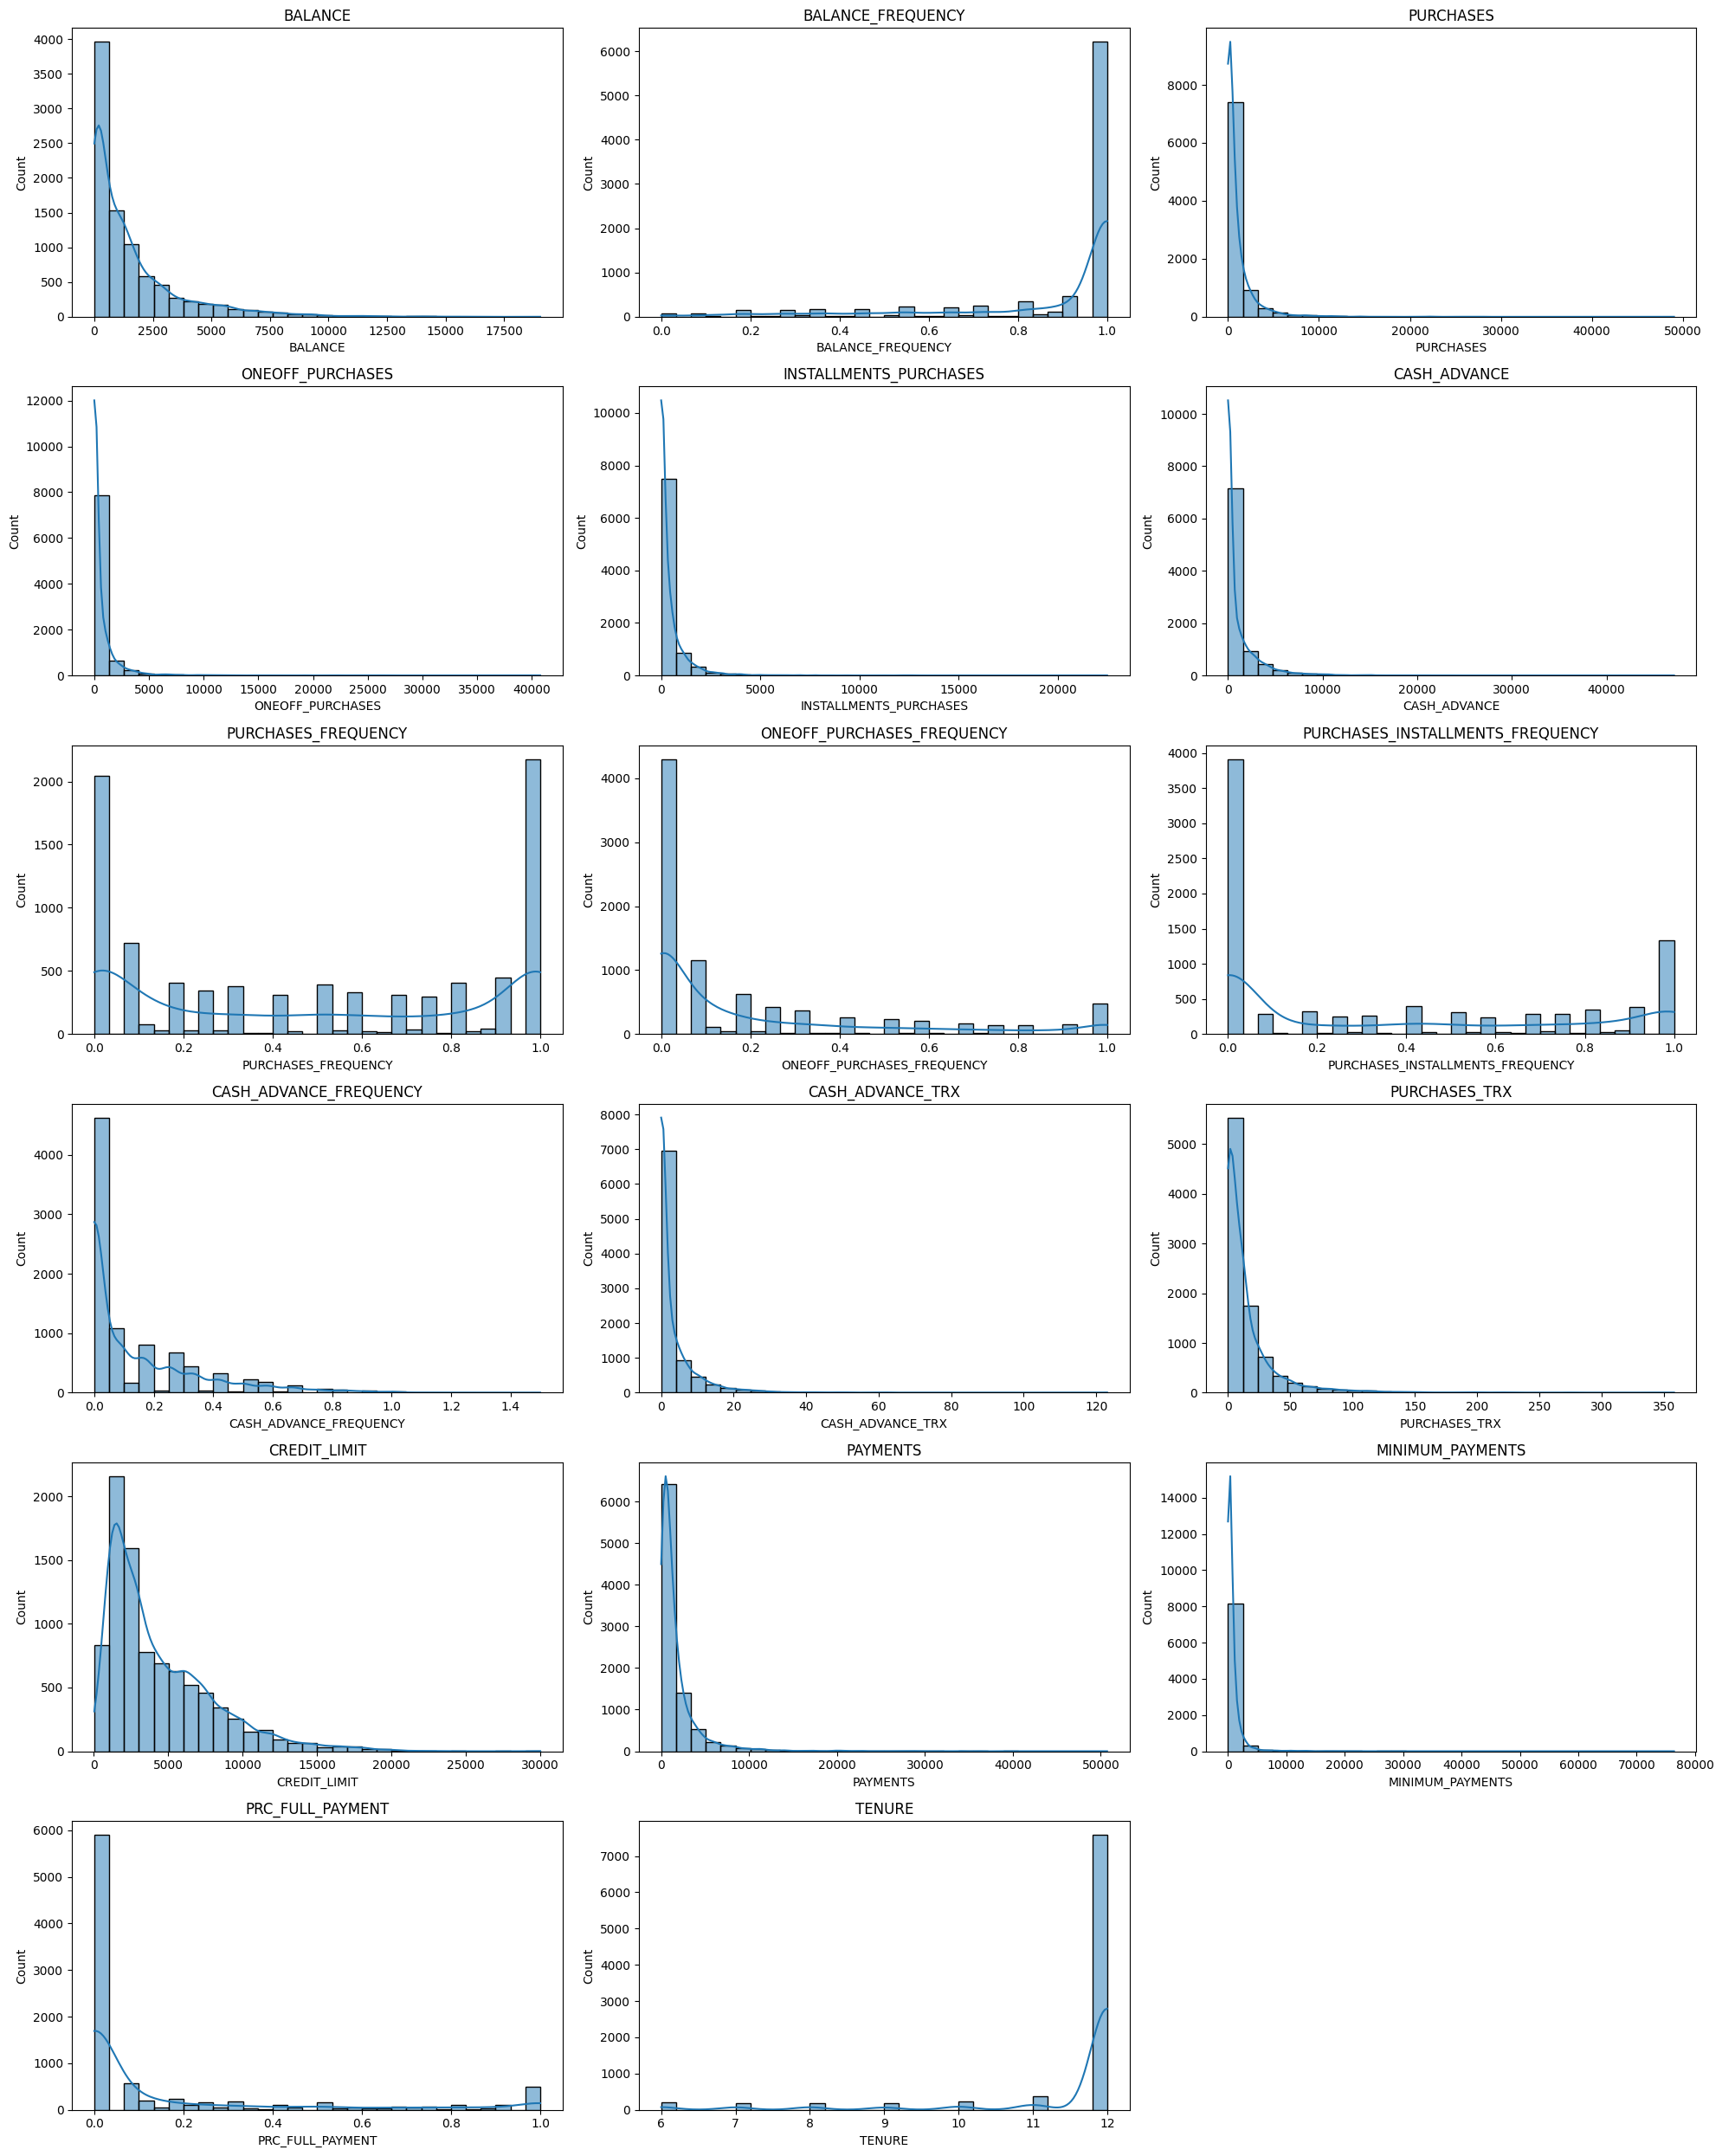

In [10]:
# -----------------------------------------
# Analyze Distribution of Numeric Features
# -----------------------------------------
numeric_df = df.select_dtypes(include=['int64', 'float64'])
basic_stats = numeric_df.describe()
skewness = numeric_df.skew()
basic_stats = basic_stats.T
basic_stats["skewness"] = skewness
print("Statistical Summary of Numeric Features:")
basic_stats
# ==============================
# Plot Distributions
# ==============================
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20, 25))
for i, column in enumerate(numeric_df.columns):
    plt.subplot(6, 3, i + 1)
    sns.histplot(numeric_df[column], bins=30, kde=True)
    plt.title(column)
plt.tight_layout()

# Display all histograms
plt.show()

### Distribution of Numeric Features
# Summary statistics (minimum, maximum, mean, standard deviation, and skewness) 
# were calculated for all numeric features.

# Skewness was examined to identify asymmetric distributions and potential 
# outliers.

# Histograms with kernel density estimation were plotted to visually 
# inspect the distribution shape of each numeric variable.

In [11]:
# -----------------------------------------
# Step: Analyze Categorical Features
# -----------------------------------------
categorical_df = df.select_dtypes(include=['object'])

for column in categorical_df.columns:
    print("Categorical Feature:", column)
    print("Number of Unique Categories:", categorical_df[column].nunique())
    print("\nValue Counts:")
    print(categorical_df[column].value_counts())
    print("\n" + "-"*50 + "\n")

# The dataset contains one categorical feature (CUST_ID).
# It has 8950 unique values, each appearing exactly once, indicating that it is a unique customer identifier.

Categorical Feature: CUST_ID
Number of Unique Categories: 8950

Value Counts:
CUST_ID
C10001    1
C10002    1
C10003    1
C10004    1
C10005    1
         ..
C19186    1
C19187    1
C19188    1
C19189    1
C19190    1
Name: count, Length: 8950, dtype: int64

--------------------------------------------------



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10444\2189818333.py:4: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_df = df.select_dtypes(include=['object'])


In [12]:
# -----------------------------------------
# Step: Identify Missing Values in the Dataset
# -----------------------------------------
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Missing Percentage (%)": missing_percentage
})
missing_summary[missing_summary["Missing Values"] > 0]

# CREDIT_LIMIT: very small missing amount (almost negligible)
# MINIMUM_PAYMENTS: moderate missing amount (~3.5%)
# Since the percentage is small, we can safely use mean imputation.

,Missing Values,Missing Percentage (%)
CREDIT_LIMIT,1,0.011173
MINIMUM_PAYMENTS,313,3.497207


In [13]:
# -----------------------------------------
# Step: Handle Missing Values 
# -----------------------------------------
df["CREDIT_LIMIT"] = df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].mean())
df["MINIMUM_PAYMENTS"] = df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean())
print("Remaining Missing Values Per Column:")
print(df.isnull().sum())
# Missing values were handled using mean imputation.


Remaining Missing Values Per Column:
CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


Correlation Matrix:


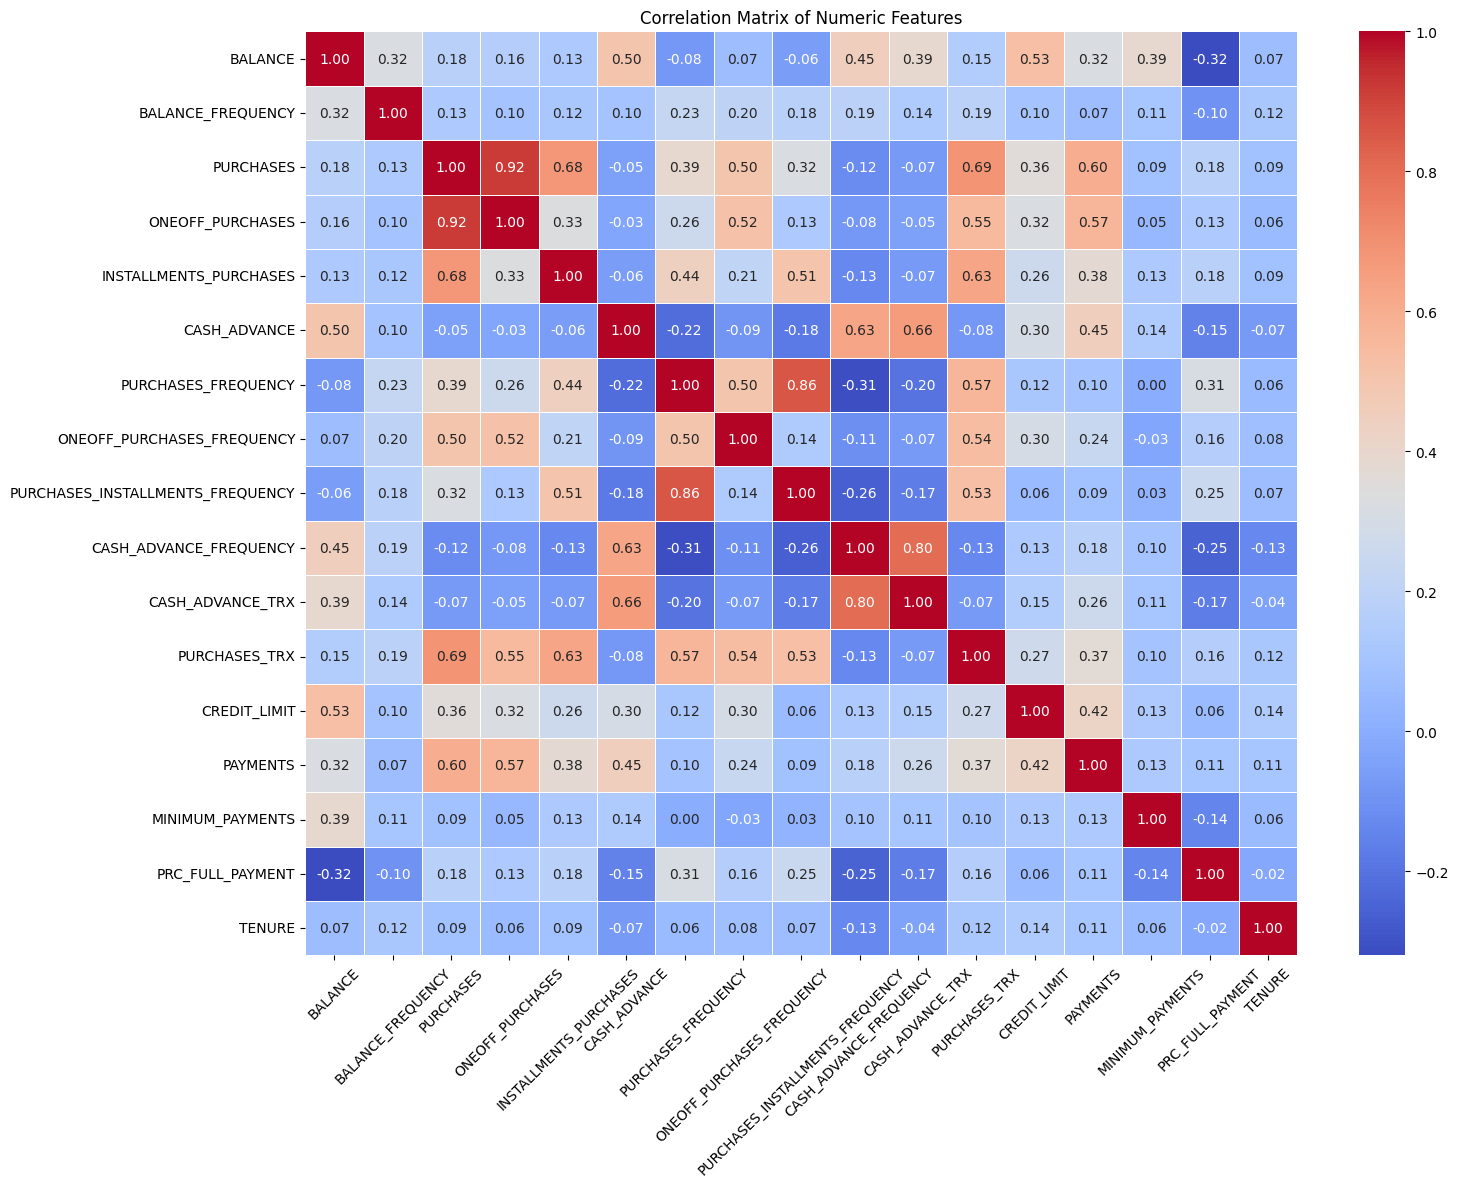

In [14]:
# -----------------------------------------
# Step: Compute Correlation Matrix for Numeric Features
# -----------------------------------------
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()
print("Correlation Matrix:")
correlation_matrix
# -----------------------------------------
# Step: Visualize Correlation Matrix with Values
# -----------------------------------------
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()
correlation_matrix = correlation_matrix.round(2)
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix,
            annot=True,            
            fmt=".2f",             
            cmap="coolwarm",       
            linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.xticks(rotation=45)
plt.show()

# The correlation matrix reveals strong positive relationships between purchase-related variables

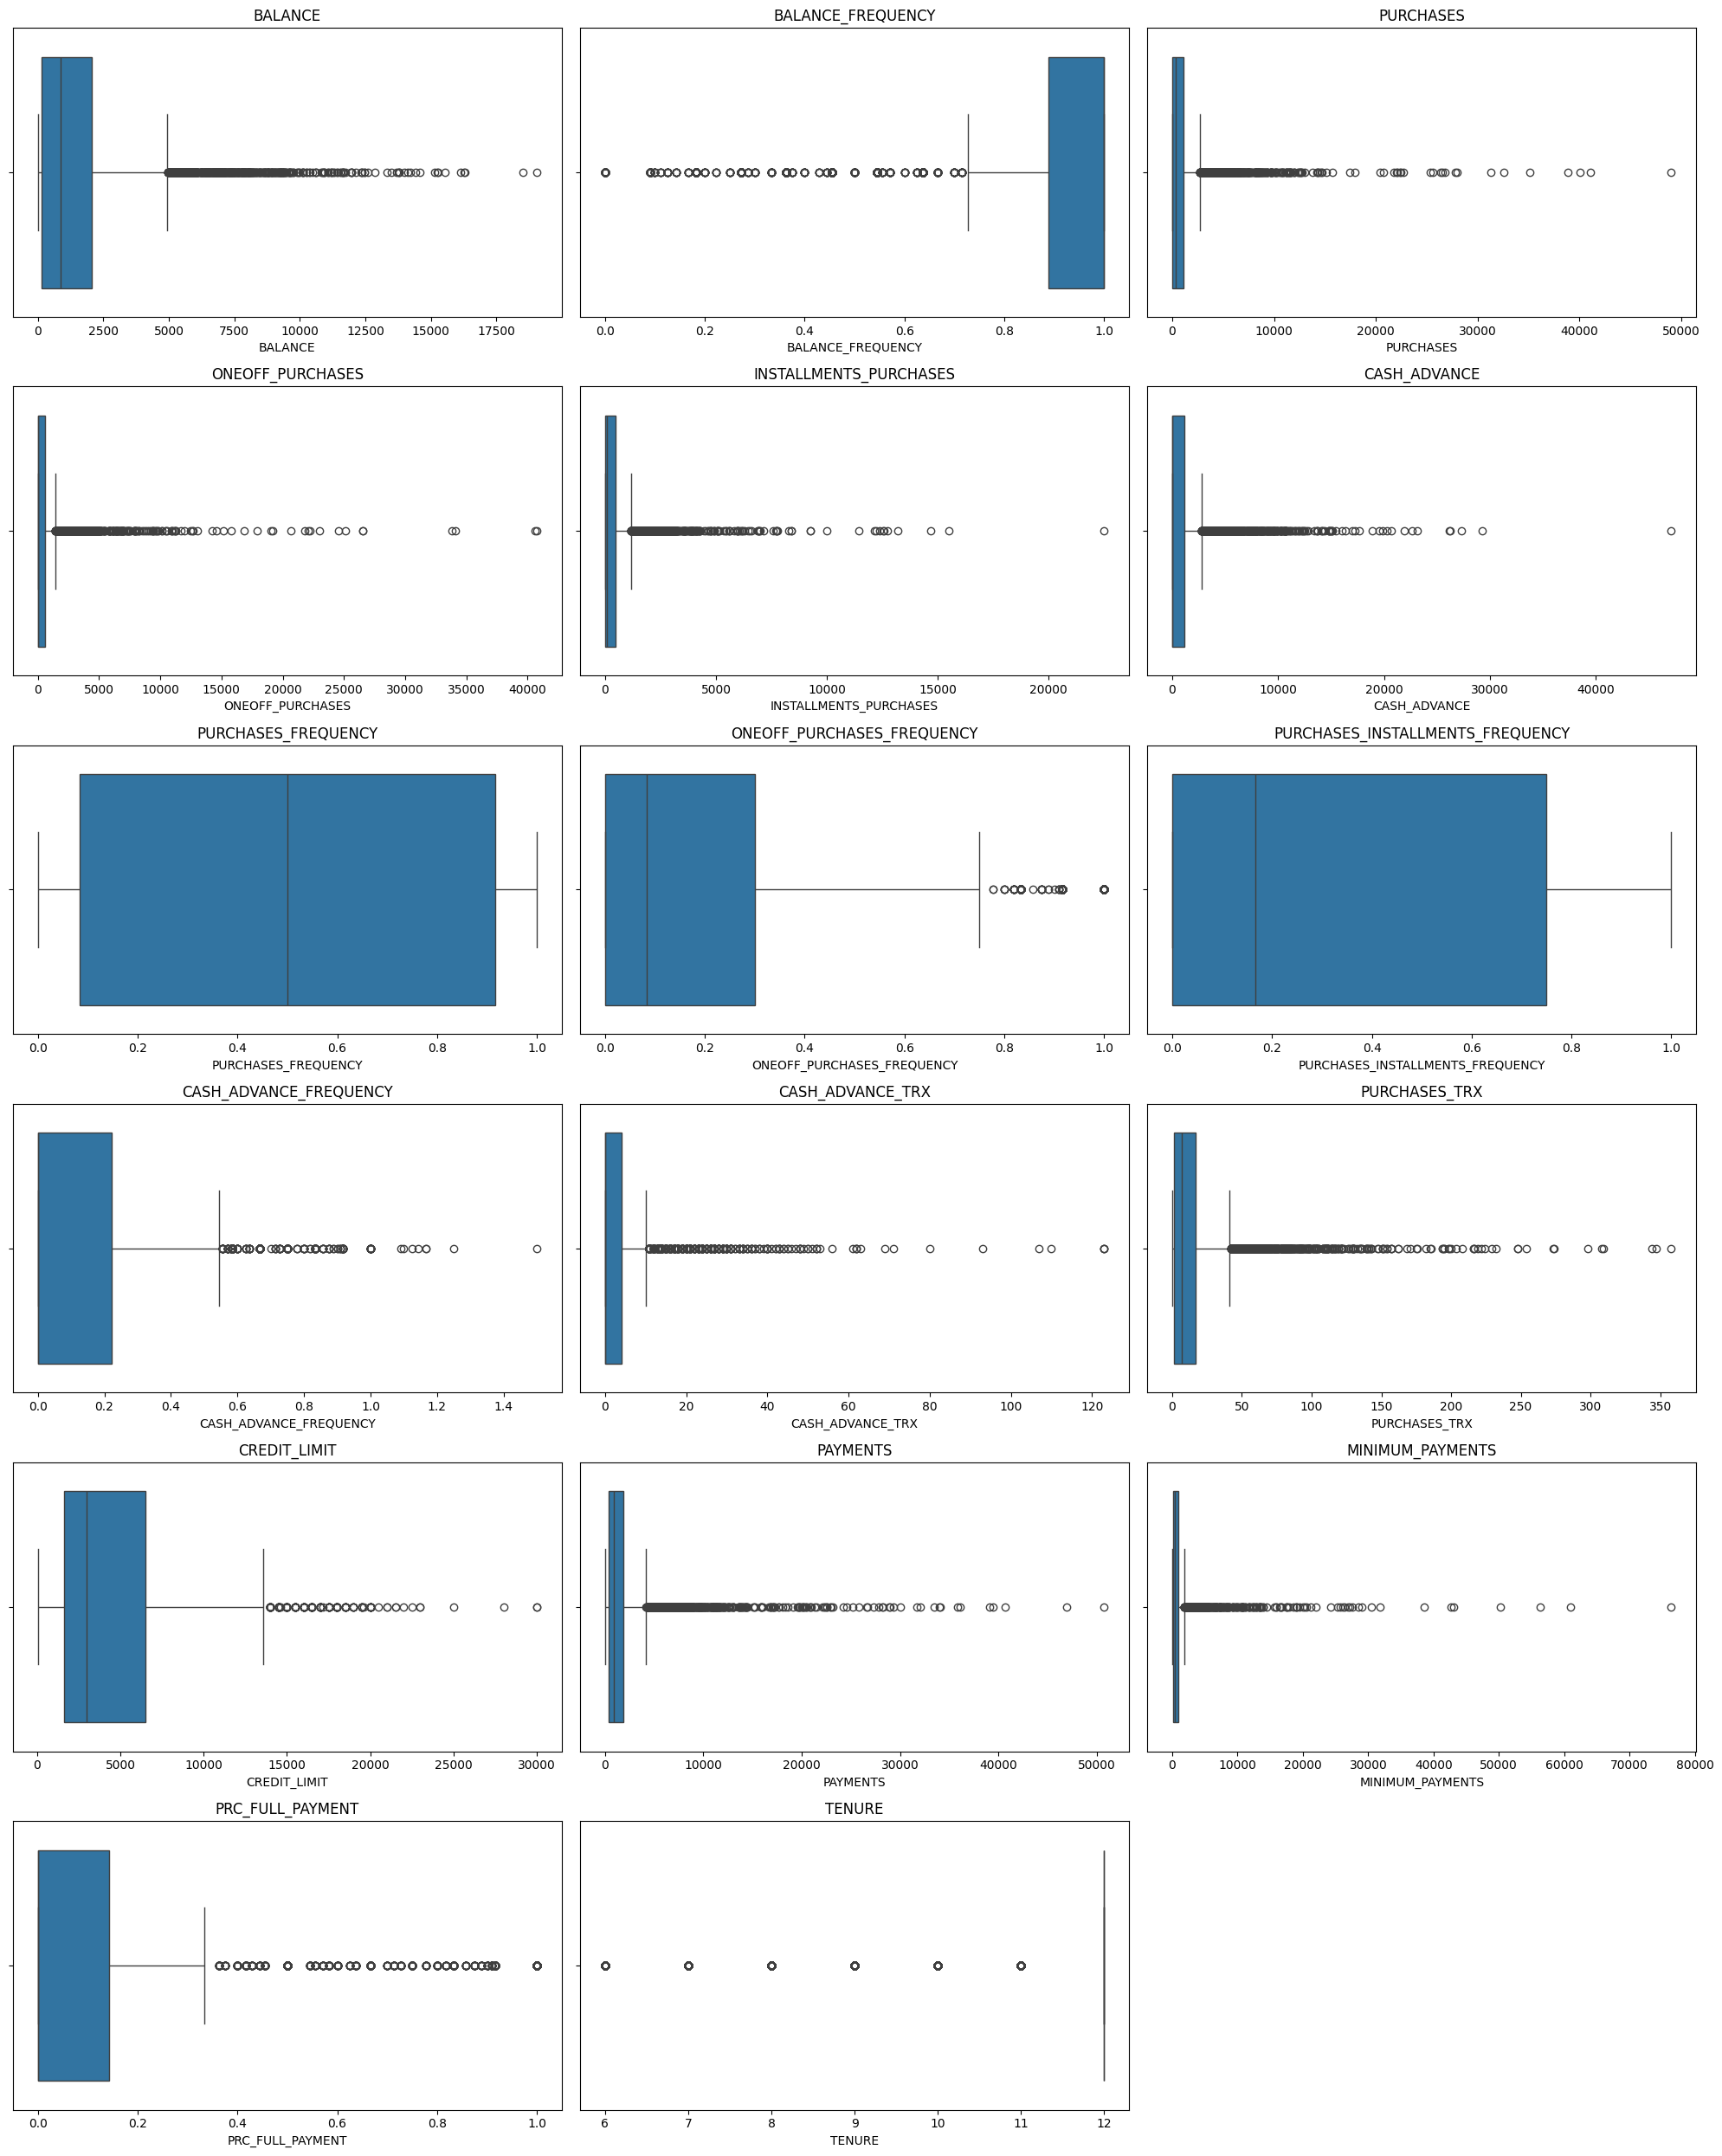

,Number of Outliers
BALANCE_FREQUENCY,1493
PRC_FULL_PAYMENT,1474
TENURE,1366
CASH_ADVANCE,1030
ONEOFF_PURCHASES,1013
INSTALLMENTS_PURCHASES,867
PAYMENTS,808
PURCHASES,808
CASH_ADVANCE_TRX,804
ONEOFF_PURCHASES_FREQUENCY,782


In [15]:
# -----------------------------------------
# Step: Detect Outliers Visually Using Boxplots
# -----------------------------------------
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20, 25))
for i, column in enumerate(numeric_df.columns):
    plt.subplot(6, 3, i + 1)
    sns.boxplot(x=numeric_df[column])
    plt.title(column)
plt.tight_layout()
plt.show()


# Create empty dictionary to store outlier counts
outlier_summary = {}

for column in numeric_df.columns:
    Q1 = numeric_df[column].quantile(0.25)
    Q3 = numeric_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = numeric_df[(numeric_df[column] < lower_bound) |
                          (numeric_df[column] > upper_bound)]
    outlier_summary[column] = len(outliers)
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index',
                                    columns=['Number of Outliers'])
outlier_df.sort_values(by='Number of Outliers', ascending=False)

# Outlier analysis using the IQR method revealed a substantial number of extreme values across multiple features. 
# In several variables, more than 15% of observations were identified as outliers. 
# These values likely represent genuine customer behavioral variability rather than data errors. 
# Therefore, instead of removing these observations, appropriate feature scaling will be applied to reduce their impact on distance-based clustering.

## 2. Data Preparation

In [16]:
# -----------------------------------------
# Drop irrelevant or non-informative columns
# -----------------------------------------
print("Columns before dropping:")
print(df.columns)

# Drop CUST_ID because:
# - It is a unique identifier for each customer
# - It does not represent behavioral information
# - Including it would distort distance-based clustering
df = df.drop("CUST_ID", axis=1)
print("\nColumns after dropping CUST_ID:")
print(df.columns)
print("\nDataset shape after dropping irrelevant column:")
print(df.shape)
# The column CUST_ID was removed during data preparation, as it represents a unique identifier and does not contain behavioral information relevant to clustering. 
# Including such a feature would negatively impact distance-based clustering methods such as DBSCAN.

Columns before dropping:
Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='str')

Columns after dropping CUST_ID:
Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='str')

Dataset shape after dropping irrelevant column:
(8950, 17)


In [17]:
# -----------------------------------------
# Step: Check for Remaining Categorical Features
# -----------------------------------------

categorical_features = df.select_dtypes(include=['object']).columns
print("Categorical Features Remaining:")
print(categorical_features)
print("Number of Categorical Features:", len(categorical_features))

# After removing the CUST_ID column, no categorical features remain in the dataset.
# Therefore, no encoding was required, and all remaining features are already in numeric format.

Categorical Features Remaining:
Index([], dtype='str')
Number of Categorical Features: 0


In [18]:
# -----------------------------------------
# Step: Scale Numeric Features for DBSCAN
# -----------------------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
X_scaled = pd.DataFrame(X_scaled, columns=df.columns)
print("First 5 rows of scaled data:")
print(X_scaled.head())

# -----------------------------------------
# Verify Scaling
# -----------------------------------------
scaled_summary = X_scaled.describe().T
print("\nMean and Standard Deviation after Scaling:")
print(scaled_summary[["mean", "std"]])
# Feature scaling was performed using StandardScaler to ensure that all variables contribute equally to distance calculations. 
# Since DBSCAN relies on distance measures to identify dense regions, 
# scaling is essential to prevent variables with larger magnitudes from dominating the clustering process.

First 5 rows of scaled data:
    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                         -0.707313   
1                   -0.678661                         -0.916995   
2     

In [19]:
# -----------------------------------------
# Step: Verify No Missing Values Exist
# -----------------------------------------
total_missing = df.isnull().sum().sum()
print("Total Missing Values in Dataset:", total_missing)
print("\nMissing Values Per Column:")
print(df.isnull().sum())
# -----------------------------------------
# Step: Verify All Features Are Numeric
# -----------------------------------------
print("Data Types of All Features:")
print(df.dtypes)
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
print("\nNon-Numeric Columns Remaining:")
print(non_numeric_columns)
# The dataset was validated after preprocessing.
# All missing values were successfully handled, and no null values remain.
# Additionally, all features are numeric, ensuring compatibility with distance-based Agglomerative Clustering.

Total Missing Values in Dataset: 0

Missing Values Per Column:
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64
Data Types of All Features:
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                  

## 3. Apply DBSCAN

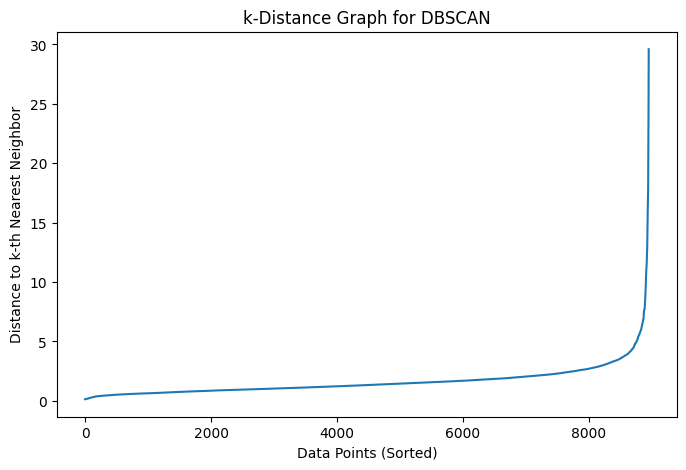

In [20]:
# -----------------------------------------
#Plot k-distance Graph to Determine eps
# -----------------------------------------

from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

min_samples = 2 * X_scaled.shape[1]
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title("k-Distance Graph for DBSCAN")
plt.xlabel("Data Points (Sorted)")
plt.ylabel("Distance to k-th Nearest Neighbor")
plt.show()

In [21]:
# -----------------------------------------
#Apply DBSCAN
# -----------------------------------------

from sklearn.cluster import DBSCAN
eps_value = 4.0  
dbscan_model = DBSCAN(
    eps=eps_value,
    min_samples=min_samples
)
dbscan_labels = dbscan_model.fit_predict(X_scaled)

df["DBSCAN_Cluster"] = dbscan_labels
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,DBSCAN_Cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [22]:
# -----------------------------------------
#Analyze Cluster Distribution
# -----------------------------------------

cluster_counts = df["DBSCAN_Cluster"].value_counts()

print("DBSCAN Cluster Distribution:")
print(cluster_counts)

noise_points = (df["DBSCAN_Cluster"] == -1).sum()

print("\nNumber of Noise Points:", noise_points)

DBSCAN Cluster Distribution:
DBSCAN_Cluster
 0    8799
-1     151
Name: count, dtype: int64

Number of Noise Points: 151


In [23]:
# DBSCAN was applied using eps = 4 and min_samples based on dataset dimensionality. 
# The algorithm identified one large cluster containing 8,799 customers and 151 noise points (approximately 1.7% of the dataset). 
# This indicates that the majority of customers form a single dense behavioral group,
# while a small subset represents outliers. The result suggests that the dataset does not contain strongly separated density-based clusters, 
# and customer behavior appears to be relatively continuous rather than forming distinct density regions

## 4. Evaluate the Clustering

In [24]:
# The DBSCAN algorithm identified one large cluster containing 8,799 customers and 151 noise points (approximately 1.7% of the dataset). 
# This indicates that the majority of customers form a single dense behavioral region,
# while a small subset was classified as outliers. Since DBSCAN detected only one cluster,
#  it suggests that the dataset does not exhibit clearly separated density-based structures. 
# Therefore, DBSCAN primarily functioned as an outlier detection method rather than a segmentation tool for this dataset.